<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [34]:
# Importar librerías
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Cargar datos en el dataframe
df = pd.read_csv('./data/datos_clientes.csv')
df.set_index('Id_Cliente', inplace=True)
df.head()

,Genero,Edad,Ingreso,Puntaje_Gasto
Id_Cliente,,,,
1,Mujer,41,98115.05,39
2,Mujer,20,35458.14,75
3,Mujer,68,59872.08,55
4,Hombre,63,48508.93,51
5,Mujer,31,44431.11,54


Primero se importan las librerías que se necesitan para el desarrollo del taller y posteriormente se procede a cargar los datos de los clientes en el dataframe 'df'.

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [16]:
# Funciones
def pruebaT(X1, X2):
    """Prueba T para dos muestras independientes.
    X1: Muestra 1.
    X2: Muestra 2.
    """
    t_statistic, p_value = stats.ttest_ind(X1, X2, equal_var=False)

    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")

    alpha = 0.05
    if p_value < alpha:
        print("La diferencia es estadísticamente significativa.")
    else:
        print("No hay evidencia suficiente para afirmar una diferencia significativa.")

def anova(df, campo):
    modelo_anova = stats.f_oneway(
        df[df['Grupo_Etario'] == '18-24'][campo],
        df[df['Grupo_Etario'] == '25-34'][campo],
        df[df['Grupo_Etario'] == '35-44'][campo],
        df[df['Grupo_Etario'] == '45-54'][campo],
        df[df['Grupo_Etario'] == '55-64'][campo],
        df[df['Grupo_Etario'] == '65+'][campo]
    )

    print(f"F-statistic: {modelo_anova.statistic}")
    print(f"P-value: {modelo_anova.pvalue}")

    alpha = 0.05
    if modelo_anova.pvalue < alpha:
        print("La diferencia entre al menos dos grupos es estadísticamente significativa.")
    else:
        print("No hay evidencia suficiente para afirmar una diferencia significativa en los grupos etarios.")

,Edad,Ingreso,Puntaje_Gasto
count,200.000000,200.000000,200.000000
mean,38.850000,60624.446600,50.200000
std,13.969007,26262.903416,25.823522
min,18.000000,13458.020000,1.000000
25%,28.750000,41512.787500,34.750000
50%,36.000000,60777.960000,50.000000
75%,49.000000,77143.865000,73.000000
max,70.000000,138584.520000,99.000000


Genero
Mujer     0.56
Hombre    0.44
Name: proportion, dtype: float64


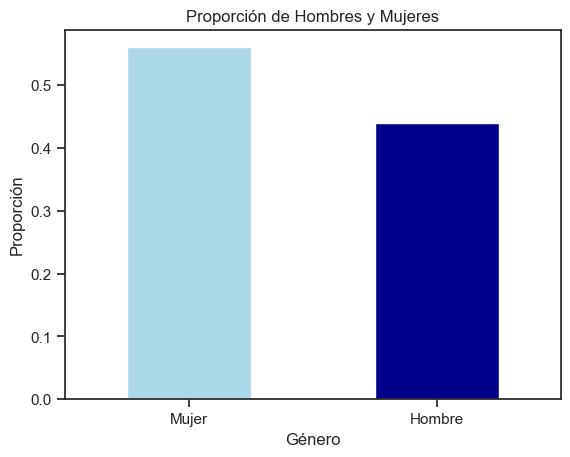

Genero
Hombre    62126.660455
Mujer     59444.135714
Name: Ingreso, dtype: float64


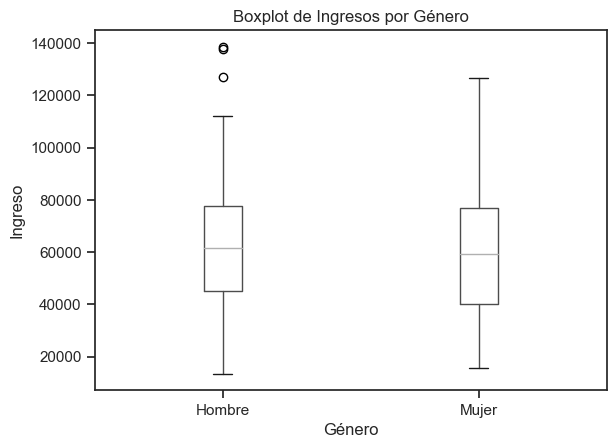

T-statistic: 0.7133855872801346
P-value: 0.4765105049312677
No hay evidencia suficiente para afirmar una diferencia significativa.
Genero
Hombre    48.511364
Mujer     51.526786
Name: Puntaje_Gasto, dtype: float64


<Figure size 800x600 with 0 Axes>

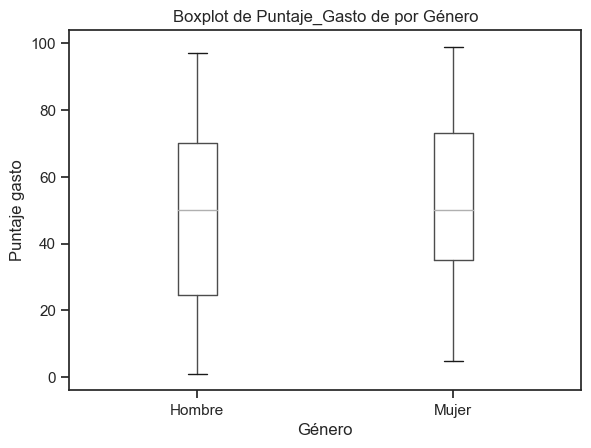

T-statistic: -0.8048781809684525
P-value: 0.42199772447783646
No hay evidencia suficiente para afirmar una diferencia significativa.


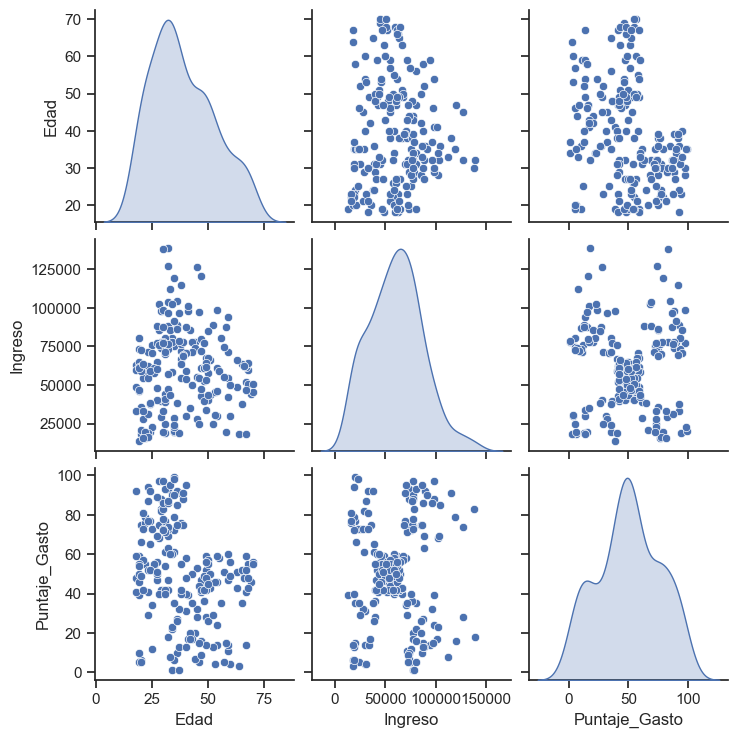

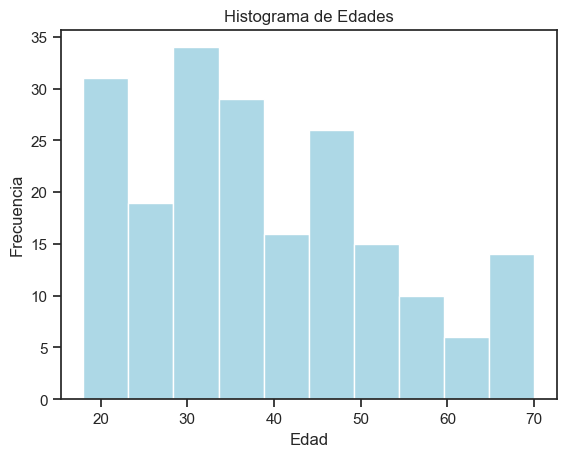

In [18]:
# Descripción de los datos
display(df.describe())

# Graficar proporción de  hombres y mujeres
proporcion_genero = df['Genero'].value_counts(normalize=True)
print(proporcion_genero)

proporcion_genero.plot(kind='bar', color=['lightblue', 'darkblue'])
plt.title('Proporción de Hombres y Mujeres')
plt.xlabel('Género')
plt.ylabel('Proporción')
plt.xticks(rotation=0)
plt.show()

# Graficar boxplot para ingreso promedio entre hombres y mujeres
ingreso_genero = df.groupby('Genero')['Ingreso'].mean()
print(ingreso_genero)

df.boxplot(column='Ingreso', by='Genero', grid=False)
plt.title('Boxplot de Ingresos por Género')
plt.suptitle('') 
plt.xlabel('Género')
plt.ylabel('Ingreso')
plt.show()

# Análisis inferencial para determinar si hay diferencias significativas entre los ingresos de hombres y mujeres
ingresos_hombres = df[df['Genero'] == 'Hombre']['Ingreso']
ingresos_mujeres = df[df['Genero'] == 'Mujer']['Ingreso']
pruebaT(ingresos_hombres, ingresos_mujeres)

# Graficar boxplot para puntaje de gasto promedio entre hombres y mujeres
gasto_genero = df.groupby('Genero')['Puntaje_Gasto'].mean()
print(gasto_genero)

plt.figure(figsize=(8, 6))
df.boxplot(column='Puntaje_Gasto', by='Genero', grid=False)
plt.title('Boxplot de Puntaje_Gasto de por Género')
plt.suptitle('') 
plt.xlabel('Género')
plt.ylabel('Puntaje gasto')
plt.show()

# Análisis inferencial para determinar si hay diferencias significativas entre los puntajes de gasto de hombres y mujeres
gastos_hombres = df[df['Genero'] == 'Hombre']['Puntaje_Gasto']
gastos_mujeres = df[df['Genero'] == 'Mujer']['Puntaje_Gasto']
pruebaT(gastos_hombres, gastos_mujeres)

# Graficar boxplot para edad promedio entre hombres y mujeres
sns.set(style="ticks")
sns.pairplot(df, diag_kind="kde")
plt.show()

# Histograma de edades
plt.hist(df['Edad'], bins=10, color='lightblue')
plt.title('Histograma de Edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Grupo_Etario
18-24    44454.795429
25-34    71157.328148
35-44    66957.096905
45-54    58786.491026
55-64    56357.093125
65+      51420.789286
Name: Ingreso, dtype: float64


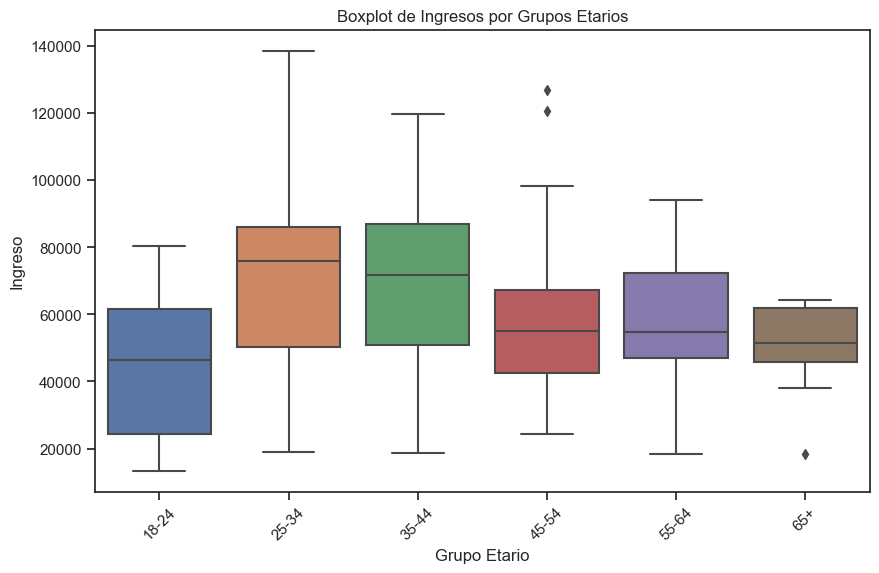

F-statistic: 6.019746307189062
P-value: 3.336261060488998e-05
La diferencia entre al menos dos grupos es estadísticamente significativa.
Grupo_Etario
18-24    56.257143
25-34    63.166667
35-44    49.428571
45-54    36.230769
55-64    32.312500
65+      46.714286
Name: Puntaje_Gasto, dtype: float64


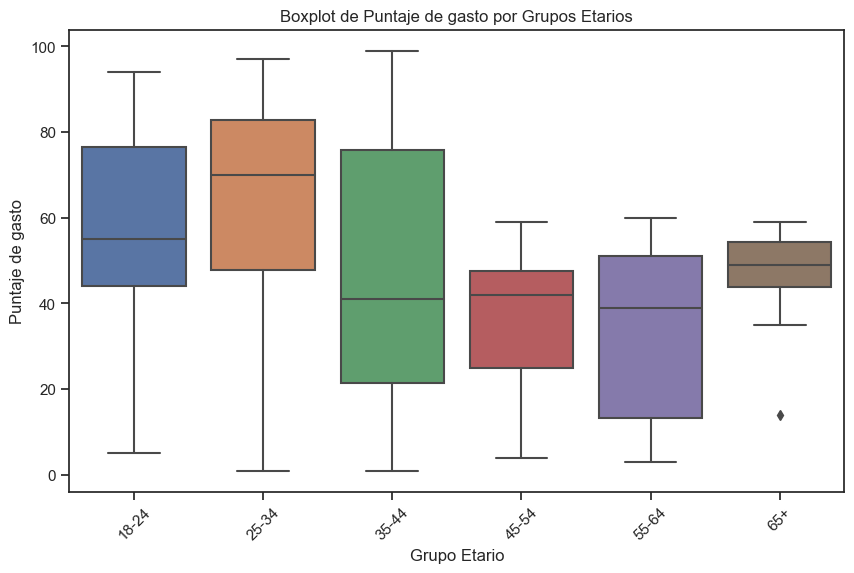

F-statistic: 8.258289721310666
P-value: 4.295829973019983e-07
La diferencia entre al menos dos grupos es estadísticamente significativa.


In [19]:
# Graficar boxplot para ingreso según grupo de edad
# Crear grupos de edades
limites_edades = [18, 25, 35, 45, 55, 65, float('inf')]
nombres_grupos = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Crear columna con grupos de edades
df['Grupo_Etario'] = pd.cut(df['Edad'], bins=limites_edades, labels=nombres_grupos, right=False)

# Graficar boxplot para ingreso según grupo de edad
ingreso_grupo = df.groupby('Grupo_Etario')['Ingreso'].mean()
print(ingreso_grupo)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Grupo_Etario', y='Ingreso')
plt.title('Boxplot de Ingresos por Grupos Etarios')
plt.xlabel('Grupo Etario')
plt.ylabel('Ingreso')
plt.xticks(rotation=45)
plt.show()

# Análisis inferencial para determinar si hay diferencias significativas entre los ingresos de los grupos etarios
anova(df, 'Ingreso')

# Graficar boxplot para puntaje de gasto según grupo de edad
gasto_grupo = df.groupby('Grupo_Etario')['Puntaje_Gasto'].mean()

print(gasto_grupo)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Grupo_Etario', y='Puntaje_Gasto')
plt.title('Boxplot de Puntaje de gasto por Grupos Etarios')
plt.xlabel('Grupo Etario')
plt.ylabel('Puntaje de gasto')
plt.xticks(rotation=45)
plt.show()

# Análisis inferencial para determinar si hay diferencias significativas entre los puntajes de gasto de los grupos etarios
anova(df, 'Puntaje_Gasto')

(Utilice este espacio para describir su procedimiento)

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

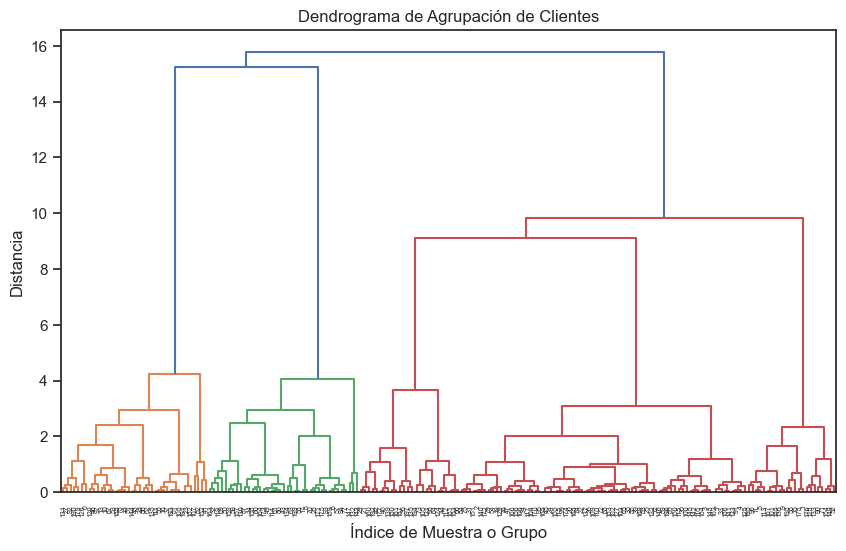

In [20]:
# Graficar boxplot para puntaje de gasto según grupo de edad y género
variables = ['Ingreso', 'Puntaje_Gasto']
data = df[variables]

# Estandarizar los datos
data_standardized = (data - data.mean()) / data.std()

# Graficar dendrograma
linked = linkage(data_standardized, 'ward', 'euclidean')

plt.figure(figsize=(10, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrograma de Agrupación de Clientes')
plt.xlabel('Índice de Muestra o Grupo')
plt.ylabel('Distancia')
plt.show()

La estandarización de variables es una práctica importante al construir dendrogramas para garantizar que todas las variables contribuyan de manera equitativa, que los resultados sean más interpretables y que los algoritmos de agrupación funcionen de manera efectiva. Esto mejora la calidad y la robustez de los análisis de clústeres.

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

Número de clusters encontrados: 5
Cluster
1    23
2    74
3    26
4    39
5    38
dtype: int64


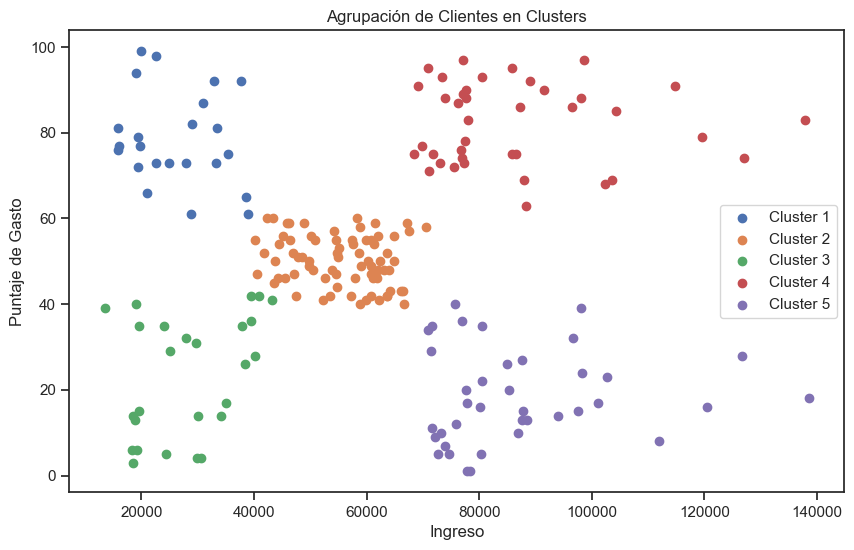

In [21]:
# Retener número de clusters con distancia 6
distancia_limite = 6
clusters = fcluster(linked, t=distancia_limite, criterion='distance')

# Agregar columna con clusters al dataframe
df['Cluster'] = clusters

# Graficar clusters
num_clusters = df['Cluster'].nunique()
print(f"Número de clusters encontrados: {num_clusters}")
print(df.groupby('Cluster').size())

plt.figure(figsize=(10, 6))
for cluster_num in range(1, num_clusters + 1):
    cluster_data = df[df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['Ingreso'], cluster_data['Puntaje_Gasto'], label=f'Cluster {cluster_num}')

plt.title('Agrupación de Clientes en Clusters')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.legend()
plt.show()

1. Establecer un límite de distancia:
    Aquí, se define un valor de distancia llamado distancia_limite que se utilizará para determinar cuántos clústeres se retendrán en el análisis. Cualquier par de observaciones con una distancia por debajo de este valor se agruparán en el mismo clúster.
2. Realizar la agrupación jerárquica:
    Se utiliza la función fcluster para realizar el análisis de clústeres aglomerativos en función de la estructura de enlace jerárquico almacenada en linked. Los clústeres se forman considerando que la distancia entre pares de observaciones no supere el valor de distancia_limite. El argumento criterion='distance' especifica que se utiliza el criterio de distancia para definir los clústeres.
3. Agregar información de clústeres al DataFrame:
    Se agrega una nueva columna llamada 'Cluster' al DataFrame df, que almacena el número de clúster al que pertenece cada observación.
4. Contar y mostrar el número de clústeres:
    Se calcula el número de clústeres únicos y se imprime en pantalla junto con el tamaño de cada clúster. Esto proporciona información sobre cuántos clústeres se han encontrado y cuántas observaciones pertenecen a cada uno.
5. Visualizar los clústeres:
    Se crea una gráfica de dispersión que muestra la agrupación de datos en clústeres. Cada clúster se representa con un color diferente en la gráfica, y las coordenadas de las observaciones en el espacio bidimensional se toman de las columnas 'Ingreso' y 'Puntaje_Gasto' del DataFrame. El título y las etiquetas de los ejes se agregan para facilitar la interpretación de la gráfica, y se muestra la leyenda que identifica cada clúster por su número.

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

Cluster
0    38
1    26
2    39
3    23
4    74
dtype: int64


/Users/gabrielgomez/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


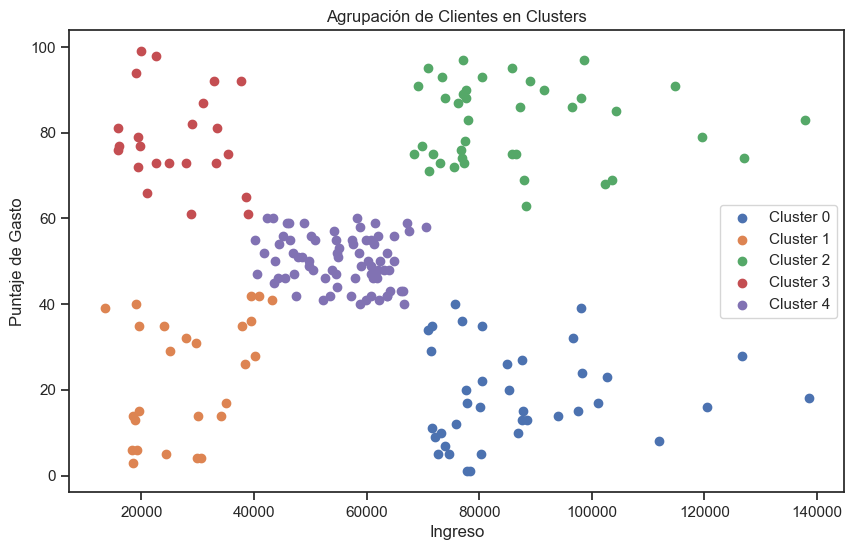

In [22]:
# Definición de número de clusters
num_clusters = max(clusters)

# Crear objeto de agrupación jerárquica
clustering = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
df['Cluster'] = clustering.fit_predict(data_standardized)

print(df.groupby('Cluster').size())

plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['Ingreso'], cluster_data['Puntaje_Gasto'], label=f'Cluster {cluster_num}')

plt.title('Agrupación de Clientes en Clusters')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.legend()
plt.show()

#### Descripción de clusters encontrados:
**Cluster 0:**
Este grupo de personas se caracteriza por tener unos ingresos altos y un puntaje de gasto muy bajo. La estrategia que se debe considerar para este grupo debe ser para aumentar la frecuencia de consumo en la tienda pues dados sus ingresos, deben poder gastar más en la tienda.

**Cluster 1:**
Este grupo de personas se caracteriza por tener ingresos bajos y un puntaje de gasto bajo también. La estrategia para este grupo debe ir enfocada en bajar los precios de algunos artículos o algunas promociones que incentiven también a aumentar los puntos de gasto.

**Cluster 2:**
Este grupo de personas se caracteriza por tener ingresos altos y un puntaje de gasto alto. Para este segmento de personas, se debe pensar en estrategias de fidelización, intentando ofrecer experiencias de exclusividad que los haga sentir bien con la tienda y que sigan con su alto consumo.

**Cluster 3:**
Este grupo de personas se caracteriza por tener puntaje de gasto alto y un ingreso bajo. Para este grupo no se aplicaría ninguna estrategia pues tienen un puntaje de gasto alto en comparación a sus ingresos.

**Cluster 4:**
Este grupo de personas se caracteriza por tener tanto un ingreso como un puntaje de gasto medio. Este grupo de clientes puede ser incluiro en la estrategia del cluster 1 pues se puede insentivar mucho más a consumir.

Ahora bien, si se está hablando de una sola estrategia de marketing, se debería considerar la más rentable, es decir, la que permita obtener mayores beneficios económicos al menor costo posible. Dado esto, el cluster 0 es el más atractivo para insentivar al consumo pues hacen parte del grupo de personas con mayores ingresos por lo cual la estrategia debería ir enfocado en ellos para que logren ser parte del cluster 2 que representa personas con alto ingreso y alto puntaje de gasto.

In [23]:
variables = ['Edad', 'Ingreso', 'Puntaje_Gasto', 'Cluster']
data = df[variables]

cluster_stats = data.groupby('Cluster').describe()

cluster_stats.round(2).T

Cluster                      0         1          2         3         4
Edad          count      38.00     26.00      39.00     23.00     74.00
              mean       40.39     44.12      32.69     25.52     43.59
              std        11.38     13.09       3.73      5.27     16.79
              min        19.00     19.00      27.00     18.00     18.00
              25%        34.00     35.00      30.00     21.50     27.00
              50%        41.50     45.50      32.00     24.00     47.50
              75%        47.00     52.75      35.50     30.00     56.50
              max        59.00     67.00      40.00     35.00     70.00
Ingreso       count      38.00     26.00      39.00     23.00     74.00
              mean    87055.07  28274.67   86537.50  26230.42  55451.26
              std     16200.10   8998.50   16684.18   7742.41   7847.57
              min     70888.72  13458.02   68486.79  15766.84  40218.68
              25%     75765.51  19362.52   75875.52  19590.81  48594.11
              50%     80570.39  28787.94   77996.30  24905.79  57359.50
              75%     95988.57  37203.28   93952.44  33157.71  61796.64
              max    138584.52  43155.28  137838.57  38950.66  70469.66
Puntaje_Gasto count      38.00     26.00      39.00     23.00     74.00
              mean       18.63     23.31      82.13     78.57     50.22
              std        10.92     13.96       9.36     10.95      5.87
              min         1.00      3.00      63.00     61.00     40.00
              25%        10.25     13.25      74.50     73.00     46.00
              50%        16.50     27.00      83.00     77.00     50.00
              75%        26.75     35.00      90.00     84.50     55.00
              max        40.00     42.00      97.00     99.00     60.00

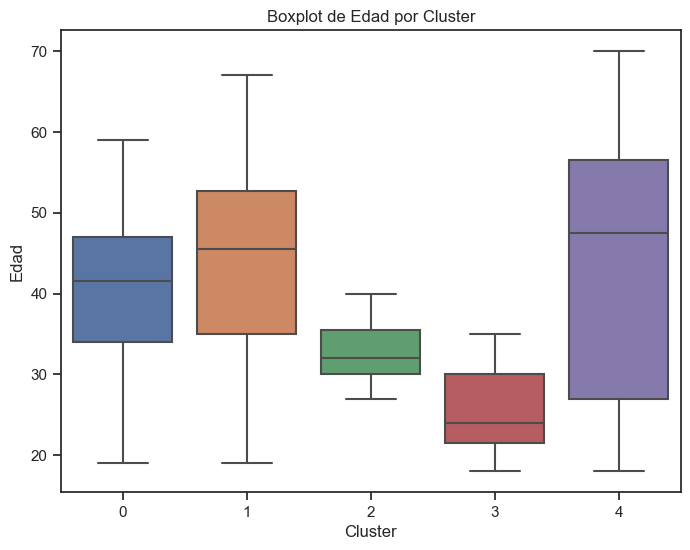

In [24]:
variables = ['Edad', 'Cluster']
data = df[variables]

plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Cluster', y='Edad')
plt.title('Boxplot de Edad por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Edad')
plt.show()

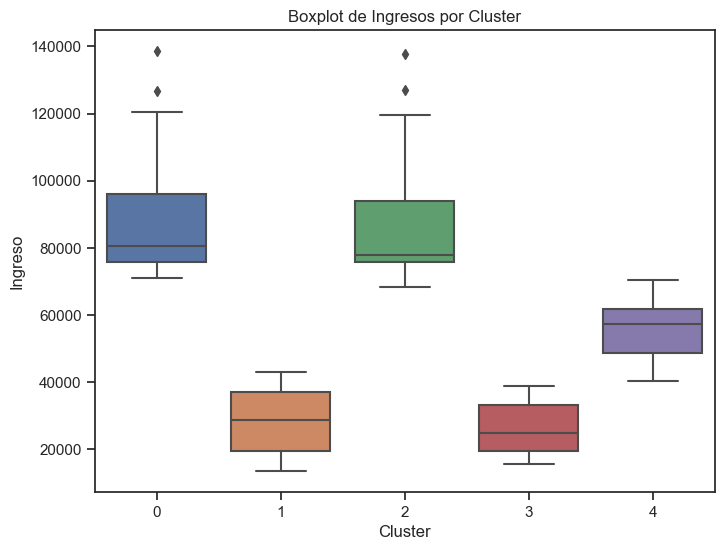

In [25]:
variables = ['Ingreso', 'Cluster']
data = df[variables]

plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Cluster', y='Ingreso')
plt.title('Boxplot de Ingresos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ingreso')
plt.show()

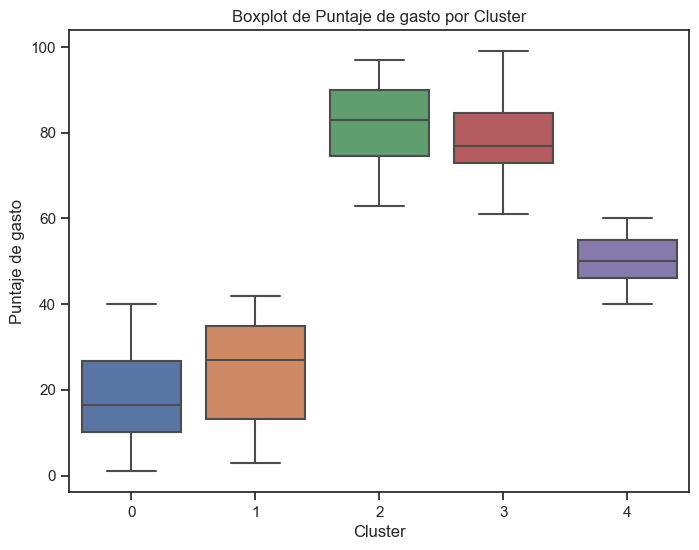

In [26]:
variables = ['Puntaje_Gasto', 'Cluster']
data = df[variables]

plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Cluster', y='Puntaje_Gasto')
plt.title('Boxplot de Puntaje de gasto por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Puntaje de gasto')
plt.show()

Genero     Hombre     Mujer
Cluster                    
0        0.526316  0.473684
1        0.384615  0.615385
2        0.461538  0.538462
3        0.391304  0.608696
4        0.418919  0.581081


<Figure size 1000x600 with 0 Axes>

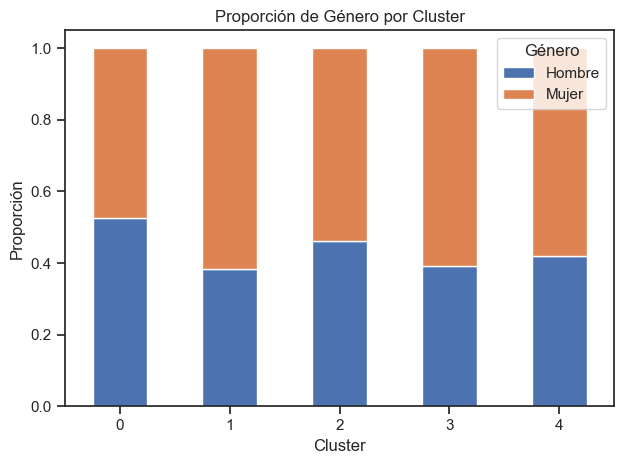

In [27]:
variables = ['Genero', 'Cluster']
data = df[variables]

proporcion_genero_por_cluster = data.groupby(['Cluster', 'Genero']).size().unstack()
proporcion_genero_por_cluster = proporcion_genero_por_cluster.div(proporcion_genero_por_cluster.sum(axis=1), axis=0)

print(proporcion_genero_por_cluster)

plt.figure(figsize=(10, 6))
proporcion_genero_por_cluster.plot(kind='bar', stacked=True)
plt.title('Proporción de Género por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporción')
plt.xticks(rotation=0)
plt.legend(title='Género')
plt.tight_layout()
plt.show()

In [28]:
df.head()

,Genero,Edad,Ingreso,Puntaje_Gasto,Grupo_Etario,Cluster
Id_Cliente,,,,,,
1,Mujer,41,98115.05,39,35-44,0
2,Mujer,20,35458.14,75,18-24,3
3,Mujer,68,59872.08,55,65+,4
4,Hombre,63,48508.93,51,55-64,4
5,Mujer,31,44431.11,54,25-34,4


(Utilice este espacio para describir su procedimiento)

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

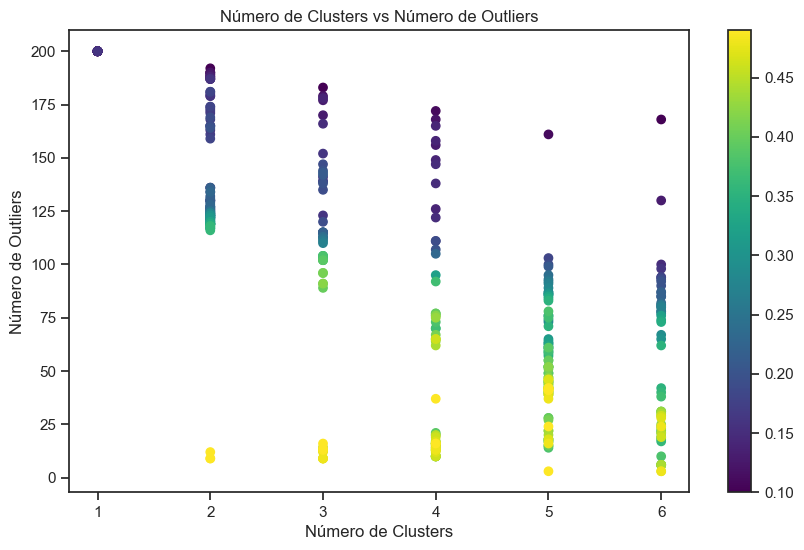

,Clusters,Eps,Min_Samples,Outliers,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
379,6,0.48,2,3,157,34,2,2,2
366,6,0.47,2,3,157,34,2,2,2
231,6,0.36,4,17,18,96,33,27,9
221,6,0.35,4,19,17,96,32,27,9
360,6,0.46,9,19,97,15,31,26,12
255,6,0.38,6,21,106,32,26,9,6
348,6,0.45,9,21,97,14,31,25,12
336,6,0.44,9,23,97,14,31,25,10
323,6,0.43,9,25,97,14,29,25,10
361,6,0.46,10,29,94,14,30,23,10


In [85]:
# Filtrar los datos
filtered_df = df[['Ingreso', 'Puntaje_Gasto']]

# Estandarizar los datos
scaler = StandardScaler()
data_standardized = scaler.fit_transform(filtered_df)

# Búsqueda exhaustiva de parámetros para DBSCAN
# Lista de clusters generados
ls_clusters = []
# Lista de eps probados
ls_eps = []
# Lista de min_samples probados
ls_min_samples = []
# Lista de outliers encontrados
ls_outliers = []
# Lista de tamaño de cluster 1
ls_cluster_1 = []
# Lista de tamaño de cluster 2
ls_cluster_2 = []
# Lista de tamaño de cluster 3
ls_cluster_3 = []
# Lista de tamaño de cluster 4
ls_cluster_4 = []
# Lista de tamaño de cluster 5
ls_cluster_5 = []

# Probar diferentes valores de eps y min_samples
for eps in np.arange(0.1, 0.5, 0.01):
    for min_samples in range(1, 15):
        # Crear objeto de agrupación DBSCAN
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        df['Cluster'] = clustering.fit_predict(data_standardized)
        num_clusters = df['Cluster'].nunique()
        # Agregar resultados a las listas si se encontraron menos de 7 clusters
        if num_clusters < 7:
            ls_clusters.append(num_clusters)
            ls_eps.append(eps)
            ls_min_samples.append(min_samples)
            ls_outliers.append(list(df['Cluster']).count(-1))
            ls_cluster_1.append(list(df['Cluster']).count(0))
            ls_cluster_2.append(list(df['Cluster']).count(1))
            ls_cluster_3.append(list(df['Cluster']).count(2))
            ls_cluster_4.append(list(df['Cluster']).count(3))
            ls_cluster_5.append(list(df['Cluster']).count(4))

# Crear dataframe con resultados
df_resultados = pd.DataFrame({
    'Clusters': ls_clusters,
    'Eps': ls_eps,
    'Min_Samples': ls_min_samples,
    'Outliers': ls_outliers,
    'Cluster_1': ls_cluster_1,
    'Cluster_2': ls_cluster_2,
    'Cluster_3': ls_cluster_3,
    'Cluster_4': ls_cluster_4,
    'Cluster_5': ls_cluster_5
})

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados['Clusters'], df_resultados['Outliers'], c=df_resultados['Eps'], cmap='viridis')
plt.title('Número de Clusters vs Número de Outliers')
plt.xlabel('Número de Clusters')
plt.ylabel('Número de Outliers')
plt.colorbar()
plt.show()

display(df_resultados[(df_resultados['Clusters'] == 6) & df_resultados['Outliers']>0].sort_values(by='Outliers'))

En esta sección se aprovecho la información privilegiada con la que se cuenta, pues en el punto anterior se definieron 5 clusters, por lo que se procedió a hacer una búsqueda exhaustiva sobre los hiperparámetros y se filtró únicamente los escenarios donde se producen 6 clusters (los 5 clusters más los outliers). Finalmente, se muestra en un dataframe el tamaño de cada cluster para poder ver más cómodamente cuál combinación de hiperparámetros genera clusters más balanceados obteniendo `eps=0.46` y `min_samples=9`.

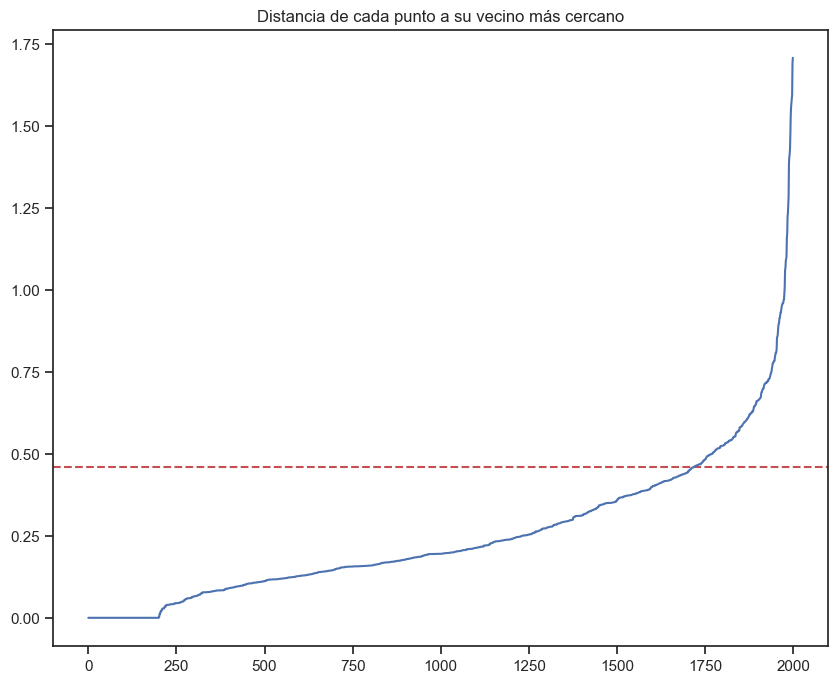

In [86]:
# Calcular la distancia desde cada punto a su vecino más cercano usando `NearestNeighbors`
neigh = NearestNeighbors(n_neighbors = 10)
nbrs = neigh.fit(data_standardized)
distancias, indices = nbrs.kneighbors(data_standardized)
distancias = np.sort(distancias.flatten())

# Graficar la distancia de cada punto a su vecino más cercano para hallar el codo
fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = 0.46, color = 'r', linestyle = '--')
plt.title('Distancia de cada punto a su vecino más cercano')
plt.plot(distancias)

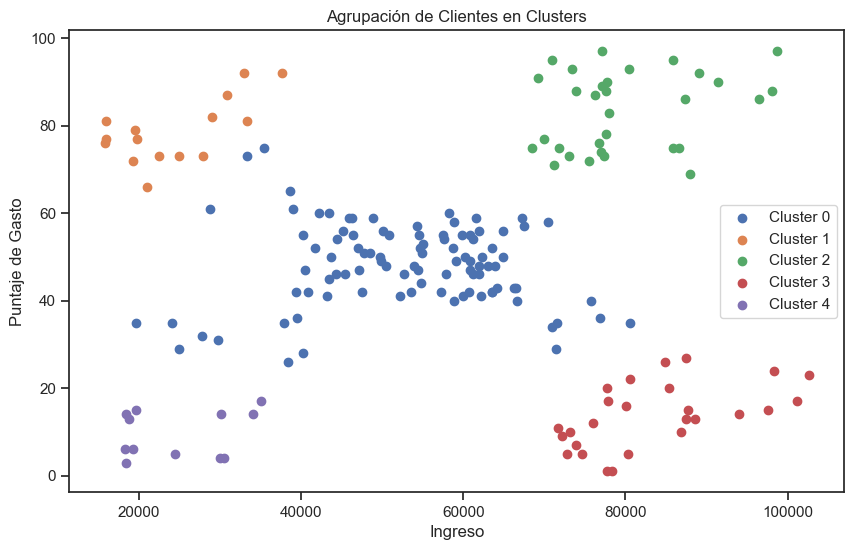

In [87]:
# Crear objeto de agrupación DBSCAN
clustering = DBSCAN(eps=0.46, min_samples=9)
df['Cluster'] = clustering.fit_predict(data_standardized)

# Graficar clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['Ingreso'], cluster_data['Puntaje_Gasto'], label=f'Cluster {cluster_num}')

plt.title('Agrupación de Clientes en Clusters')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.legend()
plt.show()

Finalmente, para comprobar y justificar correctamente el uso de `min_samples` y `eps` se calcularon las distancias entre los puntos con `NearestNeighbors` para hacer el análisis de codo o rodilla observando que efectivamente 0.46 es el punto donde más se aleja de la zona de alta densidad.

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

In [112]:
# Crear grupos de edades
limites_edades = [18, 25, 35, 45, 55, 65, float('inf')]
nombres_grupos = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

# Crear columna con grupos de edades
df['Grupo_Etario'] = pd.cut(df['Edad'], bins=limites_edades, labels=nombres_grupos, right=False)
df['Grupo_Etario'] = df['Grupo_Etario'].astype('object')

# Graficar boxplot para puntaje de gasto según grupo de edad y género
import gower

dist_g = gower.gower_matrix(df)
pd.DataFrame(dist_g)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.411990,0.364688,0.523662,0.329068,0.620721,0.349849,0.540238,0.529958,0.423533,...,0.255679,0.303806,0.117683,0.525585,0.554658,0.396330,0.411815,0.324638,0.377979,0.092660
1,0.411990,0.000000,0.387045,0.529354,0.316256,0.519380,0.362141,0.211495,0.593309,0.037184,...,0.389464,0.570769,0.338524,0.335385,0.566399,0.291980,0.491201,0.464584,0.034011,0.319330
2,0.364688,0.387045,0.000000,0.371297,0.374191,0.662443,0.437158,0.515294,0.673558,0.398588,...,0.387034,0.549108,0.380494,0.589365,0.507212,0.438052,0.429858,0.520781,0.353034,0.372107
3,0.523662,0.529354,0.371297,0.000000,0.513098,0.471418,0.609737,0.324268,0.512804,0.540897,...,0.546008,0.374749,0.509197,0.415005,0.302582,0.580360,0.558561,0.316151,0.495342,0.544686
4,0.329068,0.316256,0.374191,0.513098,0.000000,0.291654,0.113913,0.449426,0.343903,0.327799,...,0.206542,0.554513,0.271687,0.556308,0.574047,0.067262,0.344129,0.472232,0.282245,0.307836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.396330,0.291980,0.438052,0.580360,0.067262,0.245676,0.119950,0.493271,0.357136,0.261598,...,0.273804,0.621775,0.322864,0.617160,0.604309,0.000000,0.408874,0.485297,0.290146,0.313874
196,0.411815,0.491201,0.429858,0.558561,0.344129,0.499932,0.384964,0.626888,0.554698,0.502744,...,0.500827,0.662901,0.383969,0.703158,0.429918,0.408874,0.000000,0.590923,0.457190,0.453247
197,0.324638,0.464584,0.520781,0.316151,0.472232,0.378537,0.579734,0.288324,0.482801,0.445834,...,0.461583,0.136478,0.237567,0.330581,0.285678,0.485297,0.590923,0.000000,0.438940,0.354427
198,0.377979,0.034011,0.353034,0.495342,0.282245,0.520948,0.358742,0.203125,0.569502,0.045554,...,0.355453,0.536758,0.305063,0.327014,0.540756,0.290146,0.457190,0.438940,0.000000,0.319333


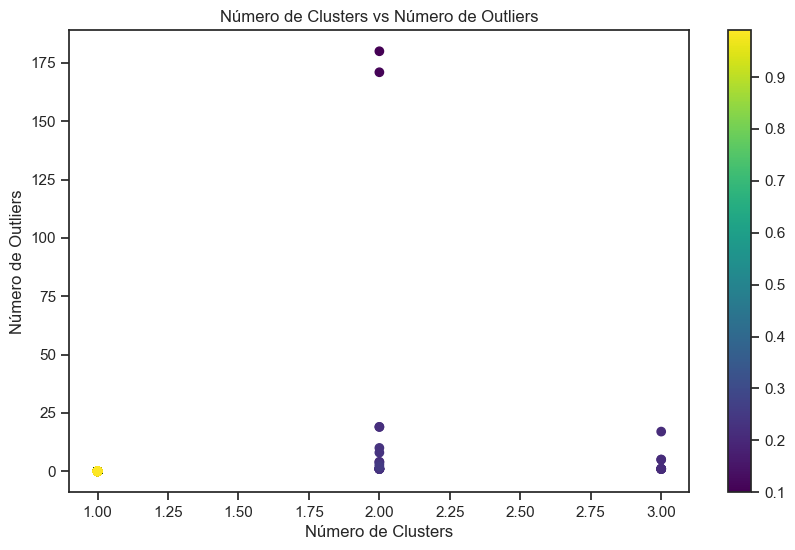

,Clusters,Eps,Min_Samples,Outliers,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5
9,3,0.21,8,1,112,87,0,0,0
10,3,0.21,9,1,112,87,0,0,0
11,3,0.21,10,1,112,87,0,0,0
12,3,0.21,11,1,112,87,0,0,0
13,3,0.21,12,1,112,87,0,0,0
14,3,0.21,13,1,112,87,0,0,0
15,3,0.21,14,1,112,87,0,0,0
16,3,0.21,15,5,109,86,0,0,0
17,3,0.21,16,5,109,86,0,0,0
18,3,0.21,17,17,97,86,0,0,0


In [153]:
# Búsqueda exhaustiva de parámetros para DBSCAN
# Lista de clusters generados
ls_clusters = []
# Lista de eps probados
ls_eps = []
# Lista de min_samples probados
ls_min_samples = []
# Lista de outliers encontrados
ls_outliers = []
# Lista de tamaño de cluster 1
ls_cluster_1 = []
# Lista de tamaño de cluster 2
ls_cluster_2 = []
# Lista de tamaño de cluster 3
ls_cluster_3 = []
# Lista de tamaño de cluster 4
ls_cluster_4 = []
# Lista de tamaño de cluster 5
ls_cluster_5 = []

limite_clusters = 4

# Probar diferentes valores de eps y min_samples
for eps in np.arange(0.1, 1, 0.01):
    for min_samples in range(1, 20):
        # Crear objeto de agrupación DBSCAN
        clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        df['Cluster'] = clustering.fit_predict(dist_g)
        num_clusters = df['Cluster'].nunique()
        # Agregar resultados a las listas si se encontraron menos de 7 clusters
        if num_clusters < limite_clusters:
            ls_clusters.append(num_clusters)
            ls_eps.append(eps)
            ls_min_samples.append(min_samples)
            ls_outliers.append(list(df['Cluster']).count(-1))
            ls_cluster_1.append(list(df['Cluster']).count(0))
            ls_cluster_2.append(list(df['Cluster']).count(1))
            ls_cluster_3.append(list(df['Cluster']).count(2))
            ls_cluster_4.append(list(df['Cluster']).count(3))
            ls_cluster_5.append(list(df['Cluster']).count(4))

# Crear dataframe con resultados
df_resultados = pd.DataFrame({
    'Clusters': ls_clusters,
    'Eps': ls_eps,
    'Min_Samples': ls_min_samples,
    'Outliers': ls_outliers,
    'Cluster_1': ls_cluster_1,
    'Cluster_2': ls_cluster_2,
    'Cluster_3': ls_cluster_3,
    'Cluster_4': ls_cluster_4,
    'Cluster_5': ls_cluster_5
})

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.scatter(df_resultados['Clusters'], df_resultados['Outliers'], c=df_resultados['Eps'], cmap='viridis')
plt.title('Número de Clusters vs Número de Outliers')
plt.xlabel('Número de Clusters')
plt.ylabel('Número de Outliers')
plt.colorbar()
plt.show()

display(df_resultados[(df_resultados['Clusters'] == limite_clusters-1)].sort_values(by='Outliers'))

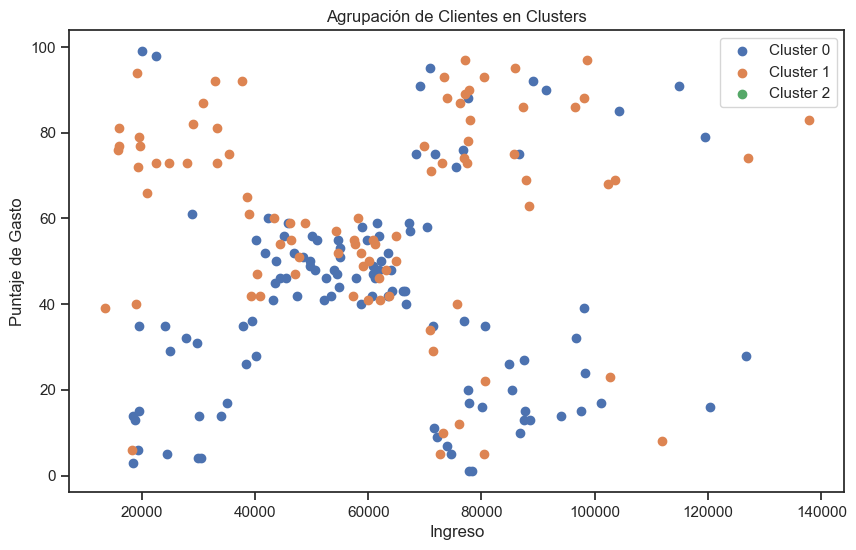

In [154]:
# Crear objeto de agrupación DBSCAN
clustering = DBSCAN(eps=0.21, min_samples=8, metric='precomputed')
df['Cluster'] = clustering.fit_predict(dist_g)
num_clusters = df['Cluster'].nunique()

# Graficar clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    # hacer scatter plot en 3D con las variables Ingreso, Puntaje_Gasto y Grupo_Etario
    
    plt.scatter(cluster_data['Ingreso'], cluster_data['Puntaje_Gasto'], label=f'Cluster {cluster_num}')

plt.title('Agrupación de Clientes en Clusters')
plt.xlabel('Ingreso')
plt.ylabel('Puntaje de Gasto')
plt.legend()
plt.show()

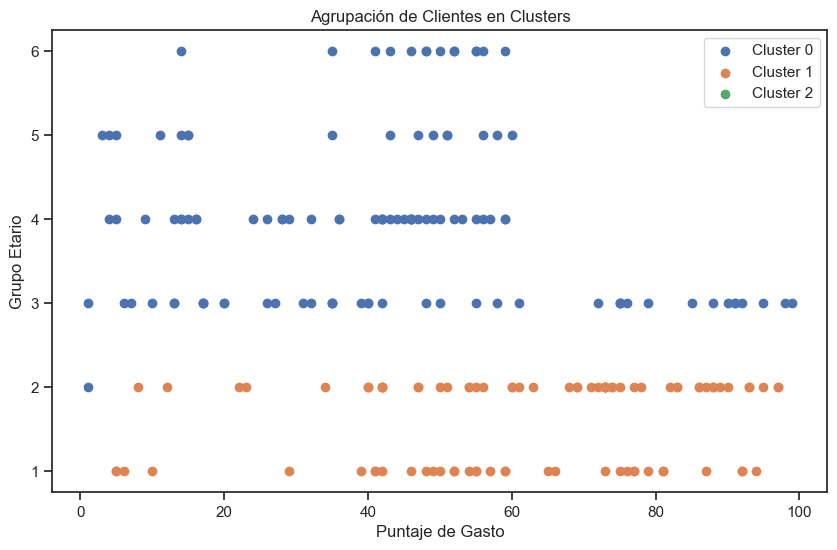

In [155]:
# Graficar clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    # hacer scatter plot en 3D con las variables Ingreso, Puntaje_Gasto y Grupo_Etario
    
    plt.scatter(cluster_data['Puntaje_Gasto'], cluster_data['Grupo_Etario'], label=f'Cluster {cluster_num}')

plt.title('Agrupación de Clientes en Clusters')
plt.xlabel('Puntaje de Gasto')
plt.ylabel('Grupo Etario')
plt.legend()
plt.show()

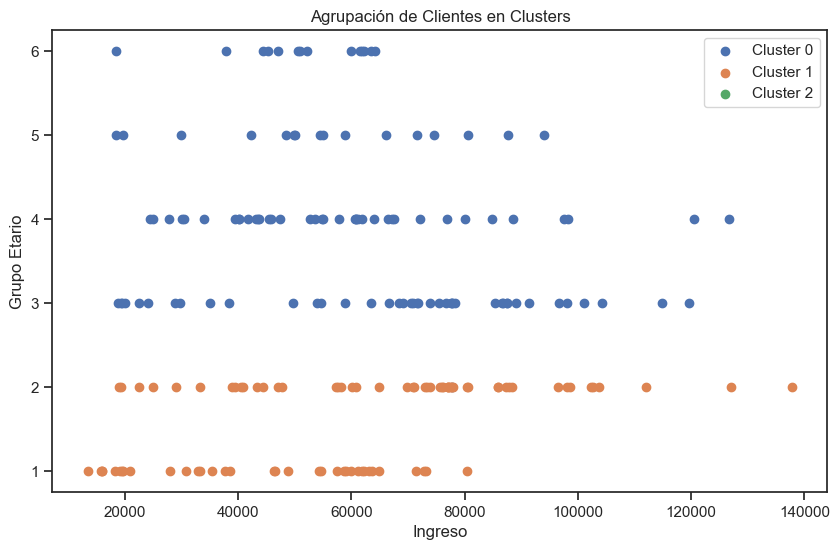

In [156]:
# Graficar clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['Ingreso'], cluster_data['Grupo_Etario'], label=f'Cluster {cluster_num}')

plt.title('Agrupación de Clientes en Clusters')
plt.xlabel('Ingreso')
plt.ylabel('Grupo Etario')
plt.legend()
plt.show()

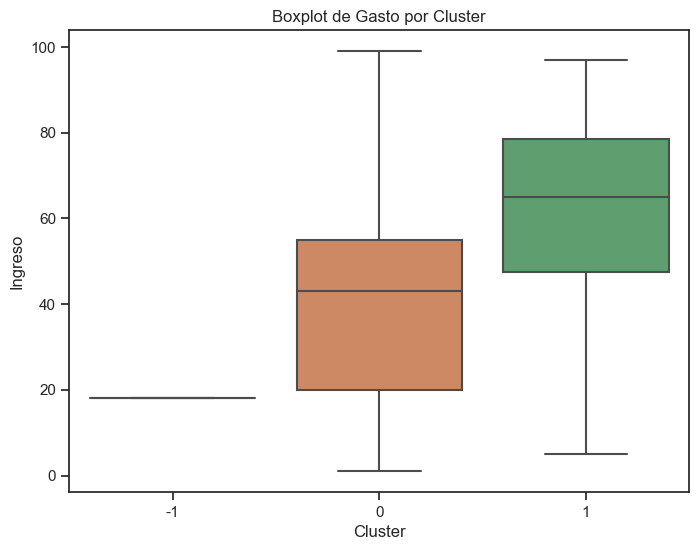

In [159]:
# Boxplot de Ingreso por Cluster
variables = ['Puntaje_Gasto', 'Cluster']
data = df[variables]

plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Cluster', y='Puntaje_Gasto')
plt.title('Boxplot de Gasto por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ingreso')
plt.show()

In [161]:
df.groupby('Cluster').describe().T

Cluster                     -1              0              1
Edad          count       1.00     112.000000      87.000000
              mean       32.00      48.660714      26.298851
              std          NaN      10.436901       5.067257
              min        32.00      34.000000      18.000000
              25%        32.00      39.750000      21.500000
              50%        32.00      48.000000      27.000000
              75%        32.00      56.250000      31.000000
              max        32.00      70.000000      34.000000
Ingreso       count       1.00     112.000000      87.000000
              mean   138584.52   60752.291339   59563.772069
              std          NaN   24582.274293   27280.797951
              min    138584.52   18434.740000   13458.020000
              25%    138584.52   43659.567500   38774.970000
              50%    138584.52   60777.830000   60769.960000
              75%    138584.52   77098.907500   77064.660000
              max    138584.52  126685.780000  137838.570000
Puntaje_Gasto count       1.00     112.000000      87.000000
              mean       18.00      41.616071      61.620690
              std          NaN      24.120660      23.498264
              min        18.00       1.000000       5.000000
              25%        18.00      20.000000      47.500000
              50%        18.00      43.000000      65.000000
              75%        18.00      55.000000      78.500000
              max        18.00      99.000000      97.000000
Grupo_Etario  count       1.00     112.000000      87.000000
              mean        2.00       4.000000       1.597701
              std          NaN       1.031049       0.493204
              min         2.00       2.000000       1.000000
              25%         2.00       3.000000       1.000000
              50%         2.00       4.000000       2.000000
              75%         2.00       5.000000       2.000000
              max         2.00       6.000000       2.000000

In [151]:
df['Grupo_Etario'].unique()
df['Grupo_Etario'].replace('18-24', 1, inplace=True)
df['Grupo_Etario'].replace('25-34', 2, inplace=True)
df['Grupo_Etario'].replace('35-44', 3, inplace=True)
df['Grupo_Etario'].replace('45-54', 4, inplace=True)
df['Grupo_Etario'].replace('55-64', 5, inplace=True)
df['Grupo_Etario'].replace('65+', 6, inplace=True)

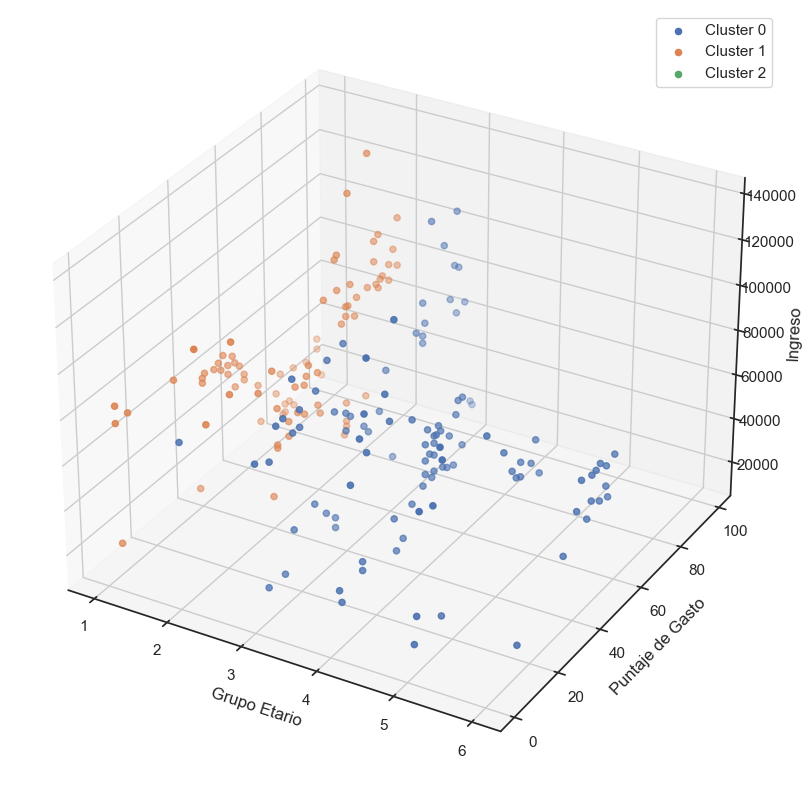

In [157]:
# hacer scatter plot en 3D con las variables Ingreso, Puntaje_Gasto y Grupo_Etario
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for cluster_num in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_num]
    ax.scatter(cluster_data['Grupo_Etario'], cluster_data['Puntaje_Gasto'], cluster_data['Ingreso'], label=f'Cluster {cluster_num}')

ax.set_xlabel('Grupo Etario')
ax.set_ylabel('Puntaje de Gasto')
ax.set_zlabel('Ingreso')
plt.legend()
plt.show()

(Utilice este espacio para describir su procedimiento)